In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.utils import compute_class_weight, resample

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_squared_error,
    r2_score,
    silhouette_score
)

from sklearn.cluster import KMeans
from kneed import KneeLocator


In [2]:
df = pd.read_csv('../data/job_en_with_skills.csv') 
group_skill_list = pd.read_csv('../data/skill.csv')['group_skill'].tolist()

In [3]:
df.head()

,company_name,city_text,exp,item_tag,company_scale,company_field,position,education,min_salary,max_salary,average_salary,platform,job_des,job_require,skills,group_skill
0,Navigos Search's Client,Hà Nội,3.0,Product Owner,NaN,Information technology,Staff,bachelor,75000000.0,125000000.0,100000000.0,vietnamworks,Mô tả công việc Navigos Search's Client is loo...,Yêu cầu công việc - A Bachelor’s degree in a r...,"agile, blockchain, data, go, performance, qa, ...","Data Systems, Languages, OS & Infrastructure, ..."
1,Navigos Search's Client,"Hà Nội, Đà Nẵng",6.0,Technical Lead (Nextjs & Nestjs) Remote,NaN,Information technology,Team leader,unknown,75000000.0,125000000.0,100000000.0,vietnamworks,Mô tả công việc What You'll Be Doing • Lead ar...,Yêu cầu công việc • 6+ years of full-stack dev...,"api, architecture, design, docker, graphql, pe...","Data Systems, Languages, Libs & Frameworks, OS..."
2,Navigos Search's Client,"Hà Nội, Đà Nẵng",6.0,Technical Lead (Nextjs & Nestjs)_Remote,NaN,Information technology,Team leader,unknown,75000000.0,125000000.0,100000000.0,vietnamworks,Mô tả công việc What You'll Be Doing • Lead ar...,Yêu cầu công việc • 6+ years of full-stack dev...,"api, architecture, design, docker, graphql, pe...","Data Systems, Languages, Libs & Frameworks, OS..."
3,Navigos Search's Client,Hà Nội,3.5,Editorial - Retouch Specialist,NaN,Information technology,Staff,unknown,75000000.0,125000000.0,100000000.0,vietnamworks,Mô tả công việcTOP 4 JOB RESPONSIBILITIES Qual...,Yêu cầu công việcRequirements & Experience • 3...,NaN,NaN
4,"RGF HR Agent Vietnam Co., LTD",Hồ Chí Minh,8.0,116935 - Principal Backend Engineer - IT softw...,NaN,Information technology,Staff,NaN,97000000.0,100000000.0,98500000.0,careerviet,Mô tả Công việc - Work Location: Phu N...,YÊU CẦU CÔNG VIỆC <Necessary Skill / Experienc...,"agile, architecture, design, docker, express, ...","Languages, Libs & Frameworks, OS & Infrastruct..."


In [4]:
from sklearn.metrics import (
    accuracy_score, r2_score, f1_score, precision_score, recall_score
)

In [5]:
# Set random seed for reproducibility
SEED = 83
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [6]:
# Data preprocessing functions
def remove_outliers_percentile(df, col, lower_pct=0.01, upper_pct=0.99):
    """Remove outliers using percentile method"""
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    return df[(df[col] >= lower) & (df[col] <= upper)]

def target_encode(df, col_name, target='average_salary'):
    """Target encoding for categorical variables"""
    return df.groupby(col_name)[target].transform('mean')

def augment_text(text, n_aug=2):
    """Text augmentation by swapping words"""
    words = text.split()
    for _ in range(n_aug):
        if len(words) > 2:
            idx1, idx2 = sorted(random.sample(range(len(words)), 2))
            words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)


In [7]:
# Data cleaning and outlier removal
df_work = remove_outliers_percentile(df.copy(), 'average_salary')

# Create salary labels (0: low, 1: medium, 2: high)
bins = [0, 8.5e6, 17e6, df['average_salary'].max()]
labels = [0, 1, 2]
df_work['salary_label'] = pd.cut(df_work['average_salary'], bins=bins, labels=labels).astype(int)

print(f"✅ Data cleaning completed. Dataset shape: {df_work.shape}")
print(f"Salary label distribution: \n{df_work['salary_label'].value_counts()}")


✅ Data cleaning completed. Dataset shape: (2985, 17)
Salary label distribution: 
salary_label
2    1761
1    1121
0     103
Name: count, dtype: int64


In [8]:
# Feature engineering
# Create numerical features from skills
df_work['num_skills'] = df_work['skills'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
df_work['num_group_skills'] = df_work['group_skill'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
df_work['has_data_skill'] = df_work['group_skill'].apply(lambda x: int('data' in str(x).lower()) if pd.notnull(x) else 0)

print("✅ Feature engineering completed")
print(f"New features created: num_skills, num_group_skills, has_data_skill")


✅ Feature engineering completed
New features created: num_skills, num_group_skills, has_data_skill


In [9]:
# Data augmentation
augmented_rows = []
for i, row in df_work.iterrows():
    if random.random() < 0.1:  # 10% chance of augmentation
        new_row = row.copy()
        new_row['job_des'] = augment_text(str(row['job_des']))
        new_row['job_require'] = augment_text(str(row['job_require'])) 
        augmented_rows.append(new_row)

df_aug = pd.DataFrame(augmented_rows)
df_work = pd.concat([df_work, df_aug], ignore_index=True)

print(f"✅ Data augmentation completed. Added {len(df_aug)} augmented samples")
print(f"Total samples after augmentation: {len(df_work)}")


✅ Data augmentation completed. Added 310 augmented samples
Total samples after augmentation: 3295


In [10]:
# Categorical encoding
categorical_cols = ['city_text', 'company_field', 'position', 'platform']
for col in categorical_cols:
    df_work[col + '_enc'] = target_encode(df_work, col)

print("✅ Categorical encoding completed")
print(f"Encoded columns: {[col + '_enc' for col in categorical_cols]}")


✅ Categorical encoding completed
Encoded columns: ['city_text_enc', 'company_field_enc', 'position_enc', 'platform_enc']


In [11]:
# Feature selection based on correlation with salary
skill_columns = [col for col in df.columns if col.startswith('skill_')]
correlations = df_work[skill_columns + ['average_salary']].corr(numeric_only=True)['average_salary'].drop('average_salary').abs()
top_group_skill = correlations.sort_values(ascending=False).head(10).index.tolist()

# Combine all features
feature_cols = top_group_skill + ['exp', 'num_skills', 'num_group_skills', 'has_data_skill'] + [col + '_enc' for col in categorical_cols]


In [12]:
# Data preparation and balancing
# Clean column names
df_work.columns = [col.replace(" ", "_").replace(".", "_").replace("-", "_") for col in df_work.columns]

# Prepare features and target
X = df_work[feature_cols].fillna(0)
y = df_work['salary_label']

# Balance the dataset
df_balanced = pd.concat([
    resample(df_work[df_work.salary_label == label], 
             replace=True, 
             n_samples=df_work['salary_label'].value_counts().max(), 
             random_state=SEED)
    for label in df_work['salary_label'].unique()
], ignore_index=True)

X = df_balanced[feature_cols].fillna(0)
y = df_balanced['salary_label']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("✅ Data preparation and balancing completed")
print(f"Number of samples after balancing: {len(df_balanced)}")
print(f"Label distribution: \n{y.value_counts(normalize=True)}")


✅ Data preparation and balancing completed
Number of samples after balancing: 5799
Label distribution: 
salary_label
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
)

print("✅ Train-test split completed")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


✅ Train-test split completed
Training set: 4639 samples
Test set: 1160 samples


In [14]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=SEED),
}

print("✅ Models defined")
print(f"Number of models: {len(models)}")
print(f"Models: {list(models.keys())}")


✅ Models defined
Number of models: 6
Models: ['Logistic Regression', 'KNN', 'Random Forest', 'Decision Tree', 'XGBoost', 'Gradient Boosting']


In [15]:


print("🎯 Result in classification (test):")
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')

        print(f"{name:<20} 🎯 Accuracy = {acc:.4f} | R² = {r2:.4f} | F1 = {f1:.4f} | Recall = {recall:.4f} | Precision = {precision:.4f}")
    except Exception as e:
        print(f"{name:<20} ❌ Error: {e}")

🎯 Result in classification (test):
Logistic Regression  🎯 Accuracy = 0.6612 | R² = 0.3364 | F1 = 0.6647 | Recall = 0.6611 | Precision = 0.6912
KNN                  🎯 Accuracy = 0.8181 | R² = 0.6261 | F1 = 0.8139 | Recall = 0.8183 | Precision = 0.8161
Random Forest        🎯 Accuracy = 0.8802 | R² = 0.7814 | F1 = 0.8790 | Recall = 0.8803 | Precision = 0.8813
Decision Tree        🎯 Accuracy = 0.8716 | R² = 0.7607 | F1 = 0.8700 | Recall = 0.8717 | Precision = 0.8743


c:\Users\vthuy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:24:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost              🎯 Accuracy = 0.8707 | R² = 0.7633 | F1 = 0.8694 | Recall = 0.8708 | Precision = 0.8712
Gradient Boosting    🎯 Accuracy = 0.7560 | R² = 0.5136 | F1 = 0.7576 | Recall = 0.7561 | Precision = 0.7615


In [16]:
# Feature Groups Definition
groups = {
    "experience": ["exp", "position_enc"],
    "skill": ["num_skills", "num_group_skills", "has_data_skill"],
    "external": ["company_field_enc", "city_text_enc"],
    "platform": ["platform_enc"]
}

print("📊 Feature Groups:")
for group_name, features in groups.items():
    print(f"{group_name.upper()}: {features}")

📊 Feature Groups:
EXPERIENCE: ['exp', 'position_enc']
SKILL: ['num_skills', 'num_group_skills', 'has_data_skill']
EXTERNAL: ['company_field_enc', 'city_text_enc']
PLATFORM: ['platform_enc']


In [17]:
# Feature Importance Analysis using Random Forest
# Get the best model (Random Forest)
best_model = models["Random Forest"]
best_model.fit(X_train, y_train)

# Get feature importance
feature_importance_scores = best_model.feature_importances_
feature_names = X_scaled.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_scores
}).sort_values('importance', ascending=False)

print("✅ Feature importance calculated using Random Forest")
print(f"Top 5 most important features:")
print(importance_df.head().to_string(index=False, float_format='%.6f'))


✅ Feature importance calculated using Random Forest
Top 5 most important features:
          feature  importance
              exp    0.245514
company_field_enc    0.175849
       num_skills    0.160429
     position_enc    0.137979
    city_text_enc    0.107310


In [18]:

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np
from scipy import stats


In [19]:
def calculate_confidence_interval(scores, confidence=0.95):
    """Calculate confidence interval for scores"""
    mean_score = np.mean(scores)
    std_error = stats.sem(scores)
    margin_error = std_error * stats.t.ppf((1 + confidence) / 2, len(scores) - 1)
    lower_bound = mean_score - margin_error
    upper_bound = mean_score + margin_error
    return mean_score, f"{lower_bound:.3f}–{upper_bound:.3f}"

In [20]:

def evaluate_model_without_features_cv(X_train, X_test, y_train, y_test, features_to_remove, n_folds=5):
    """Evaluate model performance with cross-validation after removing specific features"""
    # Get remaining features
    remaining_features = [col for col in X_train.columns if col not in features_to_remove]
    
    if len(remaining_features) == 0:
        return 0.0, 0.0, "0.000–0.000", "0.000–0.000"
    
    # Create new datasets without specified features
    X_train_reduced = X_train[remaining_features]
    X_test_reduced = X_test[remaining_features]
    
    # Combine train and test for cross-validation
    X_combined = pd.concat([X_train_reduced, X_test_reduced], ignore_index=True)
    y_combined = pd.concat([y_train, y_test], ignore_index=True)
    
    # Perform cross-validation
    model = RandomForestClassifier(n_estimators=100, random_state=SEED)
    
    # Cross-validation for accuracy
    acc_scores = cross_val_score(model, X_combined, y_combined, cv=n_folds, scoring='accuracy')
    acc_mean, acc_ci = calculate_confidence_interval(acc_scores)
    
    # Cross-validation for F1 score
    f1_scores = cross_val_score(model, X_combined, y_combined, cv=n_folds, scoring='f1_macro')
    f1_mean, f1_ci = calculate_confidence_interval(f1_scores)
    
    return acc_mean, f1_mean, acc_ci, f1_ci

# Perform ablation study with confidence intervals
ablation_results = []

# Full model (baseline) with cross-validation
acc_mean, f1_mean, acc_ci, f1_ci = evaluate_model_without_features_cv(X_train, X_test, y_train, y_test, [])
ablation_results.append({
    'model': 'full',
    'acc_mean': acc_mean,
    'acc_CI95': acc_ci,
    'f1_mean': f1_mean,
    'f1_CI95': f1_ci,
    'features_removed': 'none'
})

# Remove each feature group
for group_name, features in groups.items():
    acc_mean, f1_mean, acc_ci, f1_ci = evaluate_model_without_features_cv(X_train, X_test, y_train, y_test, features)
    ablation_results.append({
        'model': f'minus_{group_name}',
        'acc_mean': acc_mean,
        'acc_CI95': acc_ci,
        'f1_mean': f1_mean,
        'f1_CI95': f1_ci,
        'features_removed': ', '.join(features)
    })

ablation_df = pd.DataFrame(ablation_results)

print("✅ Ablation study with confidence intervals completed")
print("\n🔬 Ablation Study Results with 95% Confidence Intervals:")
print(ablation_df[['model', 'acc_mean', 'acc_CI95', 'f1_mean', 'f1_CI95']].to_string(index=False, float_format='%.4f'))



✅ Ablation study with confidence intervals completed

🔬 Ablation Study Results with 95% Confidence Intervals:
           model  acc_mean    acc_CI95  f1_mean     f1_CI95
            full    0.8838 0.880–0.888   0.8825 0.878–0.887
minus_experience    0.7360 0.724–0.748   0.7324 0.719–0.745
     minus_skill    0.7770 0.770–0.784   0.7785 0.772–0.785
  minus_external    0.7624 0.756–0.769   0.7646 0.759–0.771
  minus_platform    0.8688 0.866–0.872   0.8671 0.864–0.870


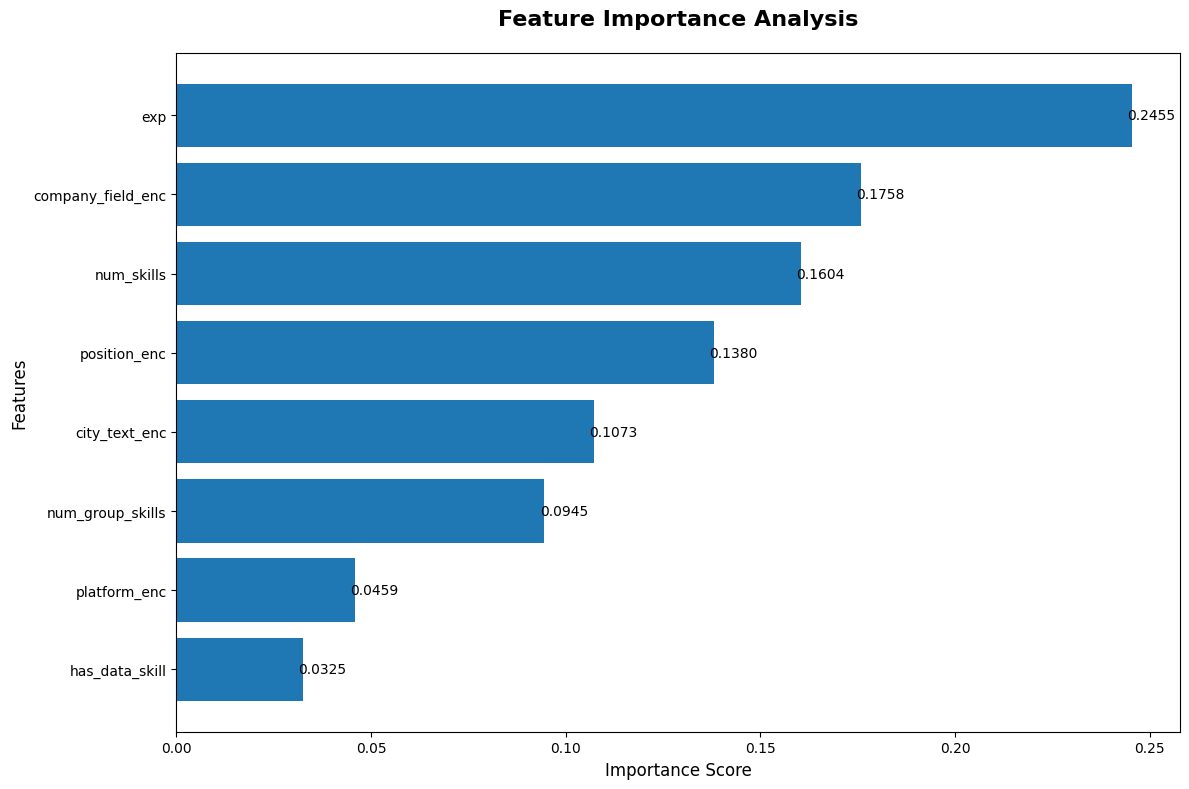

📊 Feature Importance Visualization completed


In [21]:
# Feature Importance Visualization
plt.figure(figsize=(12, 8))

# Sort features by importance
importance_sorted = importance_df.sort_values('importance', ascending=True)

# Create horizontal bar plot
bars = plt.barh(importance_sorted['feature'], importance_sorted['importance'])

plt.title('Feature Importance Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, importance_sorted['importance'])):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{value:.4f}', ha='center', va='center')

plt.tight_layout()
plt.show()

print("📊 Feature Importance Visualization completed")
